# 1. Introduccion

XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

Before choosing the problem above described, a little research has been conducted in order to decide the following items:

* Which company has maximum cab users at a particular time period?

* Does margin proportionally increase with increase in number of customers?

* What are the attributes of these customer segments?These questions will be answered in the following section.

The business problem that can be proposed is, given an investor interested in the cab industry , which cab company would be a good choice according to the methodology described below.


# 2. Data

Below are the list of datasets which are provided for the analysis:

* Cab_Data.csv – this file includes details of transaction for 2 cab companies

* Customer_ID.csv – this is a mapping table that contains a unique identifier which links the customer’s demographic details

* Transaction_ID.csv – this is a mapping table that contains transaction to customer mapping and payment mode

* City.csv – this file contains list of US cities, their population and number of cab users



In [100]:
library(forecast)
library(ggplot2)
theme_set(theme_bw())
library(gridExtra)
library(grid)
library(tseries)
library(aod)
library(seasonal)
library(lubridate)
library(dplyr)
library(readxl)
library(ggplot2)
library(GGally)
library(Hmisc)
library(corrplot)
library(PerformanceAnalytics)
library(readr)

In [101]:
Cab <- read_csv("Cab_Data1.csv", col_types = cols(`Date of Travel` = col_date(format = "%d/%m/%Y"),
                                                 Company = col_factor(levels = c("Pink Cab","Yellow Cab")), 
                                                 City = col_factor(levels = c("NEW YORK NY", 
                                                                             "CHICAGO IL", "LOS ANGELES CA", "MIAMI FL", 
                                                                             "SILICON VALLEY", "ORANGE COUNTY", "SAN DIEGO CA", 
                                                                             "PHOENIX AZ", "DALLAS TX", "ATLANTA GA", 
                                                                             "DENVER CO", "AUSTIN TX", "SEATTLE WA", 
                                                                             "TUCSON AZ", "SAN FRANCISCO CA", "SACRAMENTO CA", 
                                                                             "PITTSBURGH PA", "WASHINGTON DC", "NASHVILLE TN", 
                                                                             "BOSTON MA")),
                                                 `KM Travelled` = col_number(),  
                                                 `Price Charged` = col_number(), 
                                                 `Cost of Trip` = col_number()))

City <- read_csv("City.csv", col_types = cols(City = col_factor(levels = c("NEW YORK NY", 
                                                                           "CHICAGO IL", "LOS ANGELES CA", "MIAMI FL", 
                                                                           "SILICON VALLEY", "ORANGE COUNTY", "SAN DIEGO CA", 
                                                                           "PHOENIX AZ", "DALLAS TX", "ATLANTA GA", 
                                                                           "DENVER CO", "AUSTIN TX", "SEATTLE WA", 
                                                                           "TUCSON AZ", "SAN FRANCISCO CA", "SACRAMENTO CA", 
                                                                           "PITTSBURGH PA", "WASHINGTON DC", "NASHVILLE TN", 
                                                                           "BOSTON MA")), 
                                              Population = col_number(), Users = col_number()))


Customer <- read_csv("Customer_ID.csv", col_types = cols(Gender = col_factor(levels = c("Male", 
                                                                                      "Female")), 
                                                         Age = col_number(),
                                                         `Income (USD/Month)` = col_number()))

Transaction<- read_csv("Transaction_ID.csv", 
                    col_types = cols(Payment_Mode = col_factor(levels = c("Cash","Card"))))


After exloring the four datasets understanding the names of the columns and identifing the relationships between them, we proceed to create a master dataset joining and ordering all the four previous dataset we have. The final result would be like:

In [102]:
Cab_Transaction<-merge(Cab,Transaction,by="Transaction ID")
Cab_Transaction_Customer<-merge(Cab_Transaction,Customer,by="Customer ID")
Data<-merge(Cab_Transaction_Customer,City, by="City")
Data2<-Data[,c(3,2,10,11,12,5,1,13,14,4,6,7,8,9)]
Profit<-Data2$`Price Charged`-Data2$`Cost of Trip`
Data2<-cbind(Data2,Profit)
write.csv(Data2, file="Data2.csv")
head(Data2)

,Transaction ID,Customer ID,Gender,Age,Income (USD/Month),Company,City,Population,Users,Date of Travel,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Profit
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,10407535,27001,Female,45,11054,Pink Cab,ATLANTA GA,814885,24701,2018-11-16,36.86,497.40,438.634,Card,58.766
2,10295029,27002,Male,25,16275,Yellow Cab,ATLANTA GA,814885,24701,2018-01-19,21.66,463.01,272.916,Card,190.094
3,10149948,27002,Male,25,16275,Yellow Cab,ATLANTA GA,814885,24701,2017-03-02,3.33,79.05,47.952,Card,31.098
4,10343665,27002,Male,25,16275,Yellow Cab,ATLANTA GA,814885,24701,2018-06-29,43.29,781.18,5.506,Card,775.674
5,10056509,27003,Female,26,18450,Pink Cab,ATLANTA GA,814885,24701,2016-07-28,25.52,363.44,275.616,Card,87.824
6,10334109,27003,Female,26,18450,Yellow Cab,ATLANTA GA,814885,24701,2018-05-29,16.49,289.83,197.880,Cash,91.950


Now we proceed to identify each one of the columns, and what type of data they contain (quantitative, categorical):

* Transacction ID and Curtomer ID: variables that are only used to identify each record, and that almost certainly will never be used in any statistical analysis (name or ID number of a person, for example).

* Gender: Qualitative Binary variable with two levels of the factor (Male/Female).

* Age: Quantitative Discrete variable

* Income: Quantitative Continuous variable. Income per month of each client in USD

* Company: Qualitative Variable (Binary). The Pink cab company and yeloow cab company.

* City: Qualitative Nominal Variable. The citys where the two cab companys operate. 20 factorqs for this variable.

* Population: Quantitative Discrete variable. Number of people of each city.

* Users: Quantitative Discrete variable. Number of Users os the cab companys  of each city.

* Date of travel: Quantitative continuos variable

* Km travelled: Quantitative continuous variable. KM travelled in each trip made.

* Price charged: Quantitative continuous variable. Price in USD charged in each Trip.

* Cost of Trip: Quantitative continuous variable. Cost in USD of each Trip.

* Payment Mode: Qualitative Binary variable. Method of payement (Cach/Credit card)

## 2.1.Identification and treatment of outliers and NA


 Transaction ID      Customer ID       Gender            Age       
 Min.   :10000011   Min.   :    1   Male  :205912   Min.   :18.00  
 1st Qu.:10110810   1st Qu.: 2705   Female:153480   1st Qu.:25.00  
 Median :10221036   Median : 7459                   Median :33.00  
 Mean   :10220761   Mean   :19192                   Mean   :35.34  
 3rd Qu.:10330937   3rd Qu.:36078                   3rd Qu.:42.00  
 Max.   :10440107   Max.   :60000                   Max.   :65.00  
                                                                   
 Income (USD/Month)       Company                   City      
 Min.   : 2000      Pink Cab  : 84711   NEW YORK NY   :99885  
 1st Qu.: 8424      Yellow Cab:274681   CHICAGO IL    :56625  
 Median :14685                          LOS ANGELES CA:48033  
 Mean   :15049                          WASHINGTON DC :43737  
 3rd Qu.:21035                          BOSTON MA     :29692  
 Max.   :35000                          SAN DIEGO CA  :20488  
               

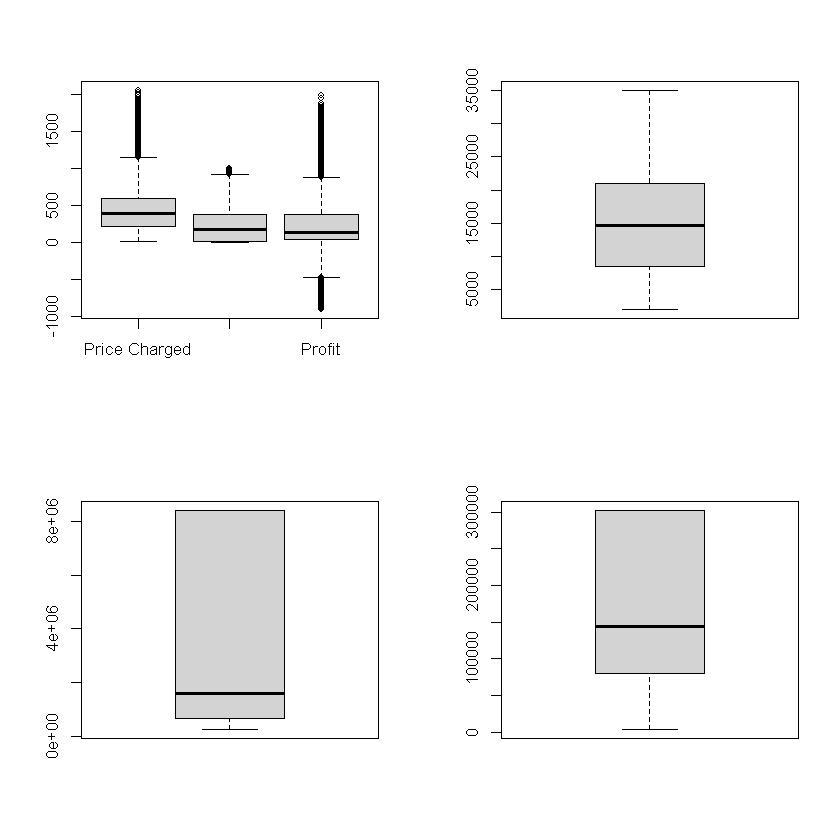

In [103]:
summary(Data2)
par(mfrow=c(2,2))
boxplot(Data2[,c(12:13,15)])
boxplot(Data2[,5])
boxplot(Data2[,8])
boxplot(Data2[,9])

In this case we see that there are outliers for the variables Price charged, cost of the trip and profits. we are going to identify the outliers, and in this case we will substitute their value for the mean of the variable.
In this case we know that these outliers are due to human errors, since charging a trip for less than it costs is clearly an error.
Once we treat the outliers, our data will be as follows:

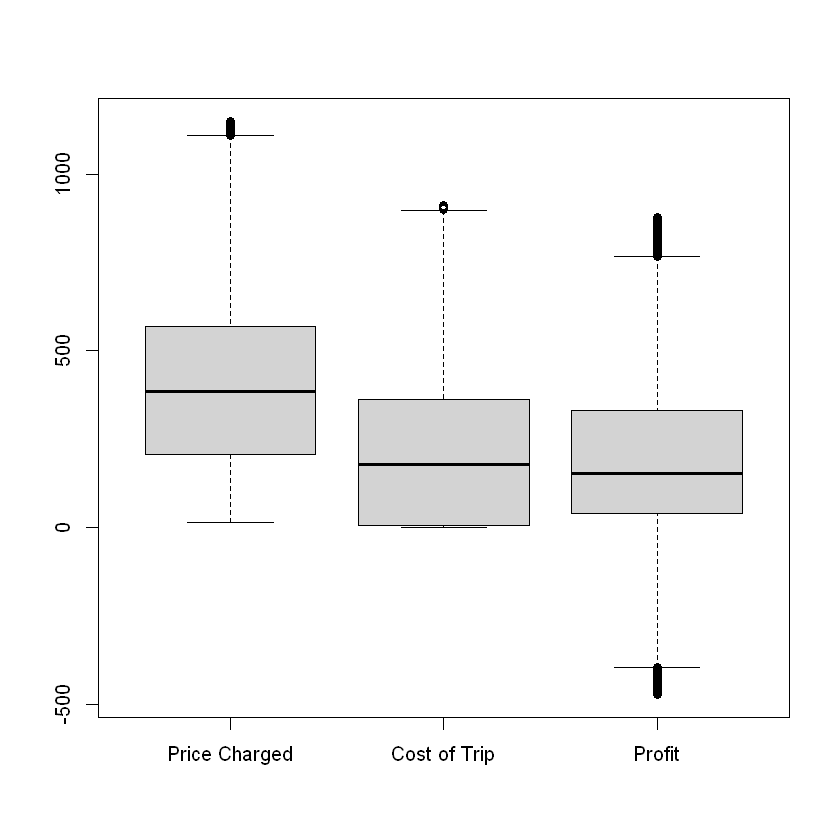

In [104]:
m1<-which(Data2$`Price Charged`<=(206.4-1.5*IQR(Data2$`Price Charged`)))
m2<-which(Data2$`Price Charged`>=(583.7+1.5*IQR(Data2$`Price Charged`)))
Data2$`Price Charged`[m1]<-mean(Data2$`Price Charged`)
Data2$`Price Charged`[m2]<-mean(Data2$`Price Charged`)

m3<-which(Data2$`Cost of Trip`<=(4.833-1.5*IQR(Data2$`Cost of Trip`)))
m4<-which(Data2$`Cost of Trip`>=(367.710+1.5*IQR(Data2$`Cost of Trip`)))
Data2$`Cost of Trip`[m3]<-mean(Data2$`Cost of Trip`)       
Data2$`Cost of Trip`[m4]<-mean(Data2$`Cost of Trip`) 


m5<-which(Data2$Profit<=(33.4 -1.5*IQR(Data2$Profit)))
m6<-which(Data2$Profit>=(370.8+1.5*IQR(Data2$Profit)))
Data2$Profit[m5]<-mean(Data2$Profit)       
Data2$Profit[m6]<-mean(Data2$Profit) 
boxplot(Data2[,c(12:13,15)])

In [105]:
which(is.na(Data2))
anyNA(Data2)

integer(0)

[1] FALSE

As we can observe, no missing values has been identified.

## 2.2 Graphic descriptive


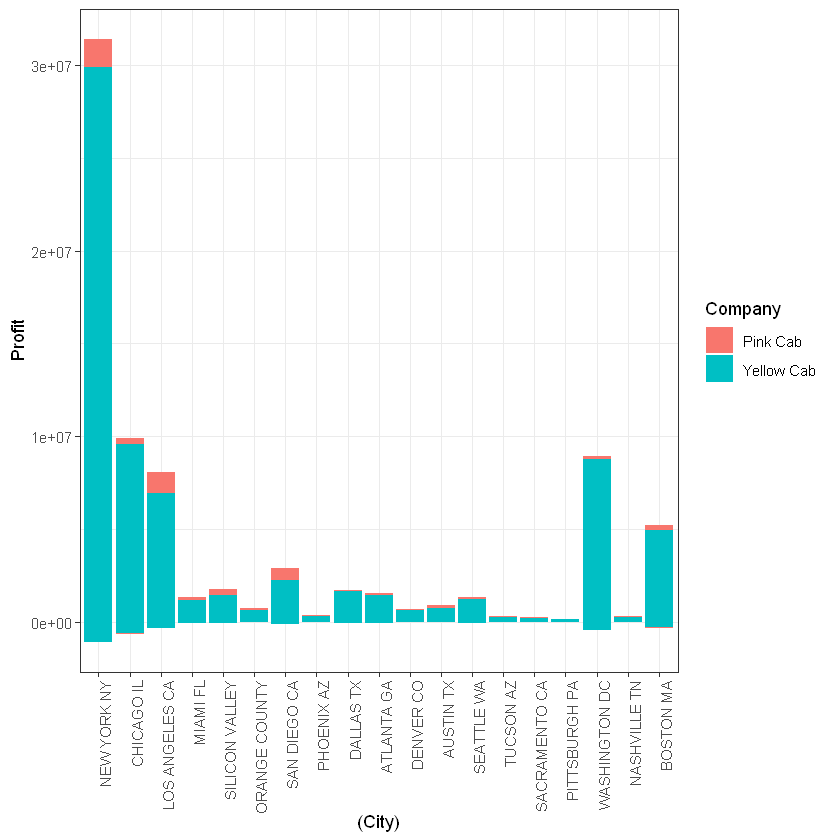

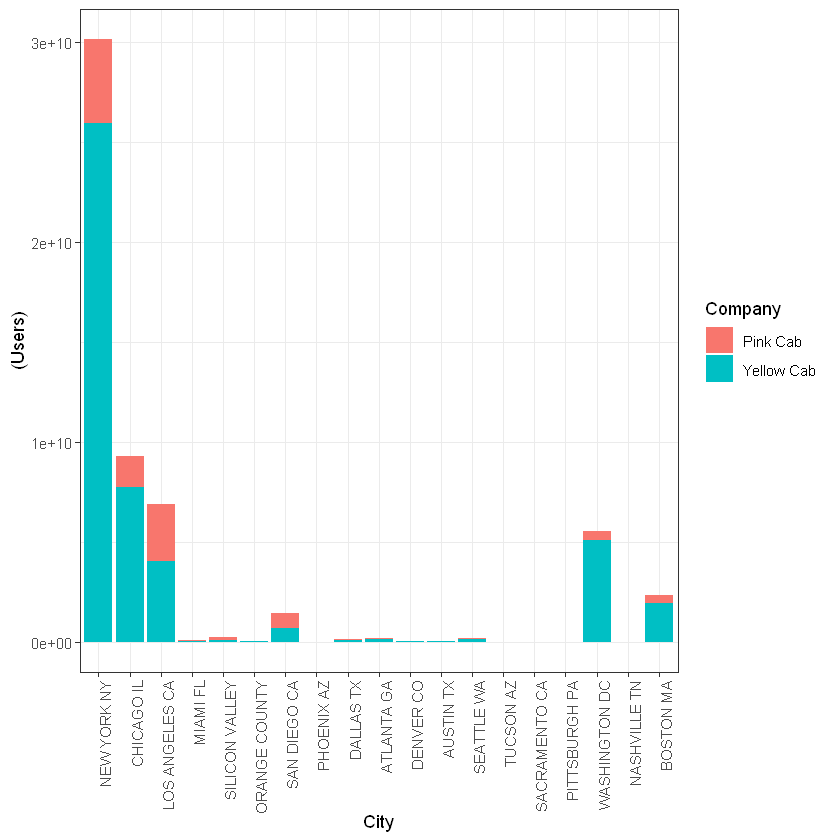

In [106]:
ggplot(Data2, aes(x=(City),fill=Company, y=Profit)) +
  geom_bar(stat="identity")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(Data2, aes(x=City,fill=Company, y=(Users))) +
  geom_bar(stat="identity")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

As we can see, there is a relationship between users of the company and the profit generated.
The yellow company clearly has a greater presence in all cities than the pink company, and generates a greater benefit in general, since it has a greater number of users.
The cities with the highest number of users and therefore economic benefit are New York, Chicago, Los Angeles and Washington.


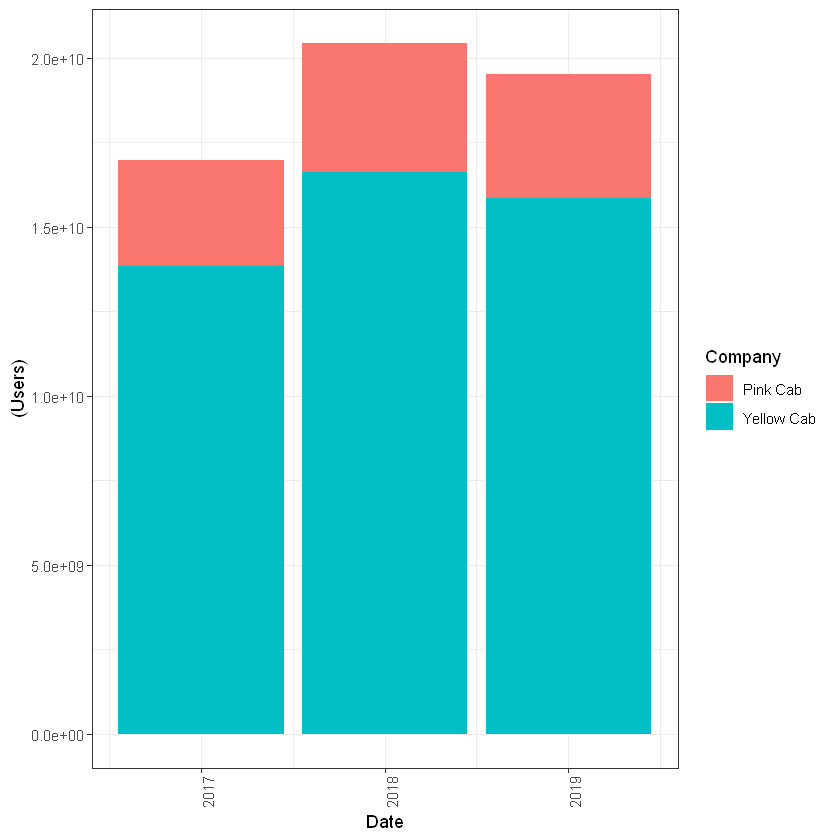

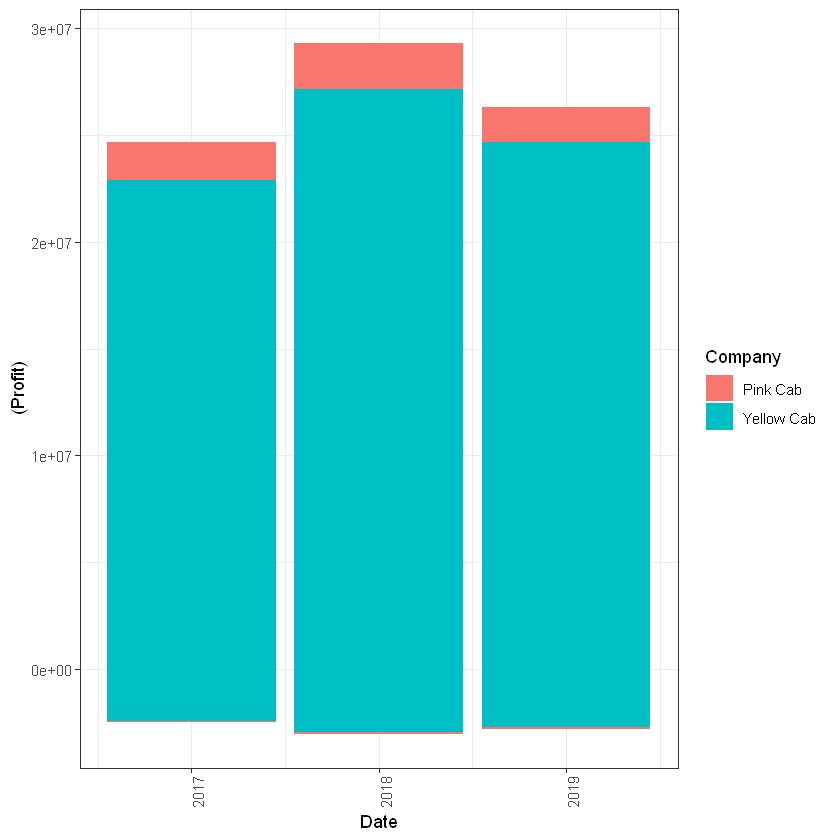

In [107]:
profityear<-data.frame(Data2$`Date of Travel`,(Data2$`Price Charged`-Data2$`Cost of Trip`),Data2$Users,Data2$Company)
profityear<-profityear[order(profityear$Data2..Date.of.Travel.), ]
colnames(profityear)<-c("Date","Profit","Users","Company")
profityear$Date<-ceiling_date(profityear$Date, unit=c( "year"))

ggplot(profityear, aes(x=Date, fill= Company,y=(Users))) +
  geom_bar(stat="identity")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(profityear, aes(x=Date, fill= Company,y=(Profit))) +
  geom_bar(stat="identity")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


In this case, we analyze the number of users and profit generated by each of the companies over the three years. As we can see, the yellow company has the largest number of users over the three years, with the largest number of users in 2017.
In the case of the benefits generated, the yellow company is superior to the pink one, with a higher profit in 2017.



# 3.Time series analysis for profits

## 3.1 Descriptive

In this case we are going to study the profit that each of the companies has over time. The idea is to understand which of the two companies will generate a greater profit in the future, and which will make it more interesting for the investor.



In [108]:
yellow<-filter(Data2, Company == "Yellow Cab")
yellowT<-data.frame(yellow$`Date of Travel`,(yellow$`Price Charged`-yellow$`Cost of Trip`))
yellowT<-yellowT[order(yellowT$yellow..Date.of.Travel.), ]
colnames(yellowT)<-c("Date","Profit")
yellowT$Date<-ceiling_date(yellowT$Date, unit=c("month", "year"))
yellowT<-aggregate(Profit ~ Date, yellowT, sum)



Pink<-filter(Data2,Company == "Pink Cab")
PinkT<-data.frame(Pink$`Date of Travel`,(Pink$`Price Charged`-Pink$`Cost of Trip`))
PinkT<-PinkT[order(PinkT$Pink..Date.of.Travel.), ]
colnames(PinkT)<-c("Date","Profit")
PinkT$Date<-ceiling_date(PinkT$Date, unit=c("month", "year"))
PinkT<-aggregate(Profit ~ Date, PinkT, sum)

Warning message in parse_period_unit(unit):
"Unit argument longer than 1. Taking first element."
Warning message in parse_period_unit(unit):
"Unit argument longer than 1. Taking first element."


ETS(M,N,M) 

Call:
 ets(y = yellow, model = "ZZZ") 

  Smoothing parameters:
    alpha = 0.3264 
    gamma = 7e-04 

  Initial states:
    l = 1859190.7701 
    s = 1.4849 1.2863 1.2555 1.1717 0.9193 0.8367
           0.8779 0.9149 0.8154 0.8361 0.7195 0.8819

  sigma:  0.107

     AIC     AICc      BIC 
1017.462 1041.462 1041.215 

Training set error measures:
                  ME     RMSE     MAE        MPE     MAPE      MASE       ACF1
Training set 1192.22 139129.9 99012.4 -0.9383157 6.277702 0.3706552 0.04015797
ETS(M,N,M) 

Call:
 ets(y = Pink, model = "ZZZ") 

  Smoothing parameters:
    alpha = 0.3446 
    gamma = 1e-04 

  Initial states:
    l = 157561.5286 
    s = 2.2939 1.8595 1.5909 1.0832 0.8865 0.6772
           0.5316 0.3807 0.5469 0.6706 0.5793 0.8997

  sigma:  0.167

     AIC     AICc      BIC 
859.2666 883.2666 883.0194 

Training set error measures:
                   ME     RMSE     MAE       MPE     MAPE      MASE        ACF1
Training set -1749.18 17148.66 12307.

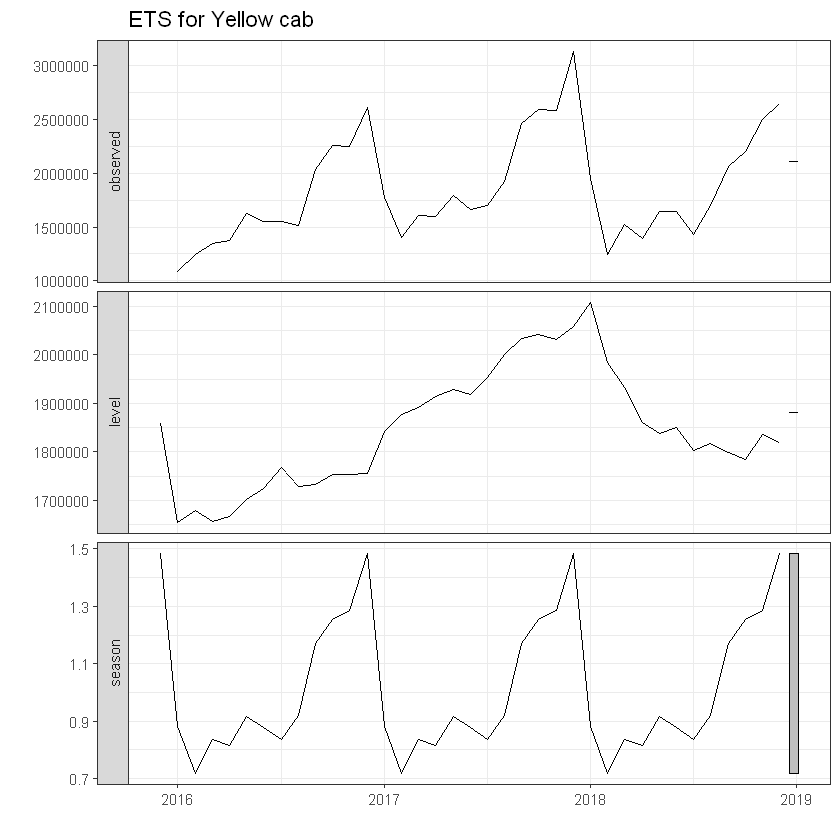

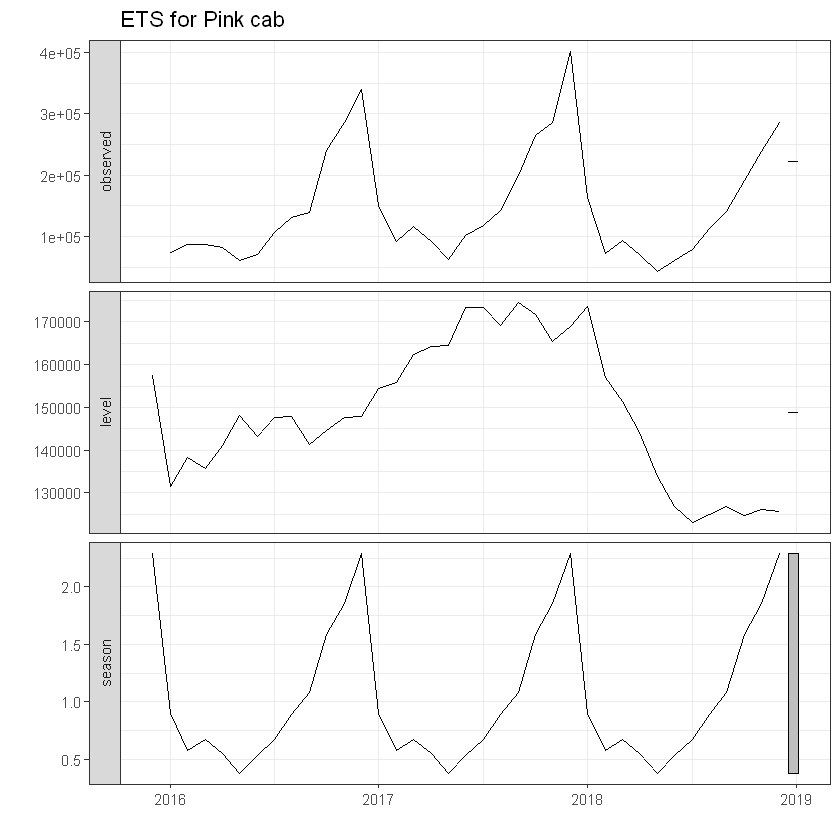

In [109]:
yellow <- ts(yellowT$Profit, start = c(2016,1) , frequency =12)
yellowmulti<-(decompose(yellow))
yellowets<-ets(yellow,model = "ZZZ")
summary(yellowets)
autoplot(yellowets,main="ETS for Yellow cab")

Pink <- ts(PinkT$Profit, start = c(2016,1) , frequency = 12)
pinkmulti<-(decompose(Pink))
pinkets<-ets(Pink,model = "ZZZ")
summary(pinkets)
autoplot(pinkets,main="ETS for Pink cab")

Observing the series we see that a clearly upward trend for both companies. It seems that there is a seasonality for the months of December.
According to what the MAPE value indicates, the prediction error for the yellow company is 6.27% and for the pink company it is 11.27%.
With an error less than or close to 10% we will continue with this model for prediction.

## 3.2.Seasonal component


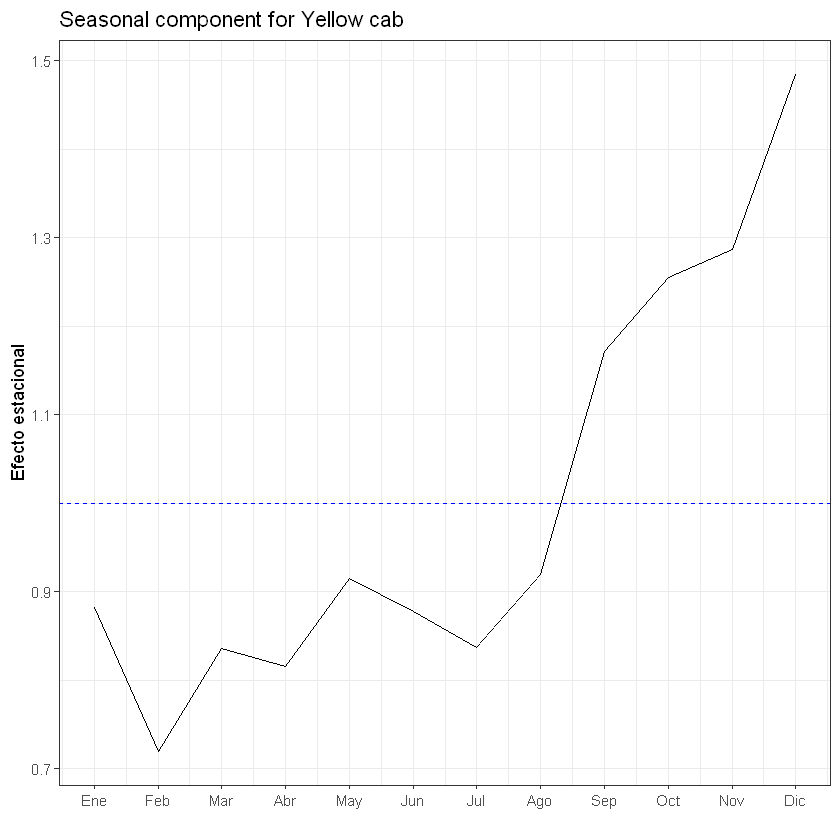

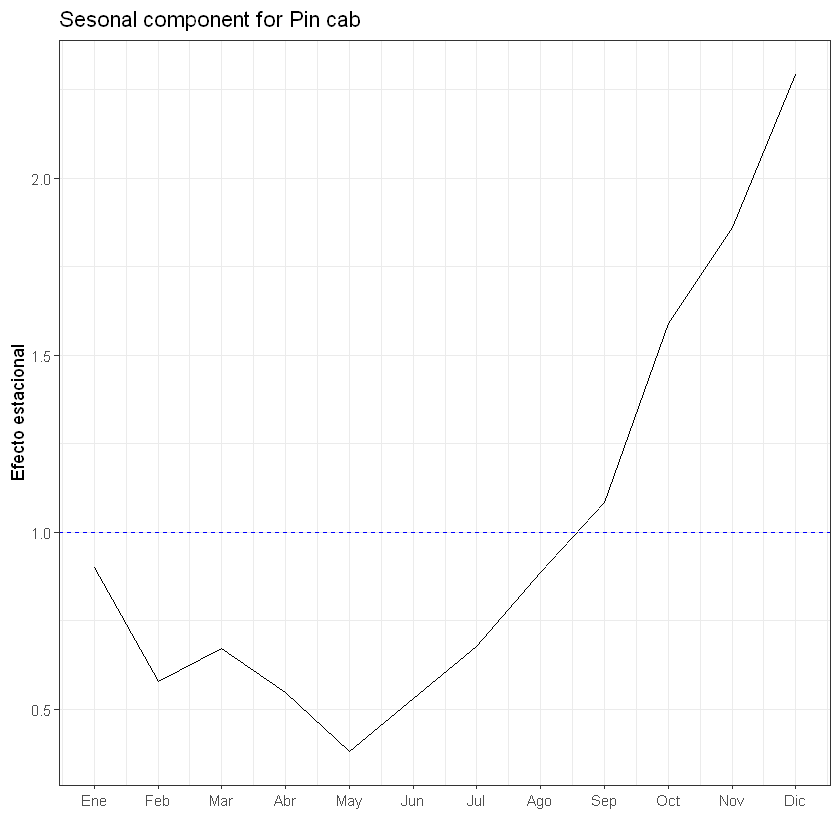

In [110]:
TT <- nrow(yellowets$states)
componenteEstacional <- yellowets$states[TT, 13:2]

ggplot() +
geom_line(aes(x = 1:12, y = componenteEstacional)) +
geom_hline(yintercept = 1, colour = "blue", lty = 2) +
ggtitle("Seasonal component for Yellow cab") +
xlab("") +
ylab("Efecto estacional") +
scale_x_continuous(breaks= 1:12,
labels = c("Ene", "Feb", "Mar", "Abr", "May", "Jun",
"Jul", "Ago", "Sep", "Oct", "Nov", "Dic"))

TT <- nrow(pinkets$states)
componenteEstacional <- pinkets$states[TT, 13:2]

ggplot() +
geom_line(aes(x = 1:12, y = componenteEstacional)) +
geom_hline(yintercept = 1, colour = "blue", lty = 2) +
ggtitle("Sesonal component for Pin cab") +
xlab("") +
ylab("Efecto estacional") +
scale_x_continuous(breaks= 1:12,
labels = c("Ene", "Feb", "Mar", "Abr", "May", "Jun",
"Jul", "Ago", "Sep", "Oct", "Nov", "Dic"))


We can observe a clear seasonality in both cases. The fourth quarter of the year seems to have a clear increase in the profit obtained by each company. While from January to July, the profits of both companies are average, we see an increase from August, having a very high peak in December. This may be due to holiday periods, since we understand that in December due to Christmas there is an increase in the use of cab companys.



## 3.3 Forecast and outliers


         Point Forecast   Lo 95   Hi 95
Jan 2019        1603809 1267353 1940264
Feb 2019        1308462 1019557 1597367
Mar 2019        1520560 1168857 1872263
Apr 2019        1482863 1124967 1840759
May 2019        1664004 1246306 2081702
Jun 2019        1596642 1180975 2012308
Jul 2019        1521762 1111884 1931641
Aug 2019        1672033 1207091 2136975
Sep 2019        2131130 1520476 2741784
Oct 2019        2283516 1610389 2956644
Nov 2019        2339586 1631162 3048010
Dec 2019        2700728 1861818 3539638

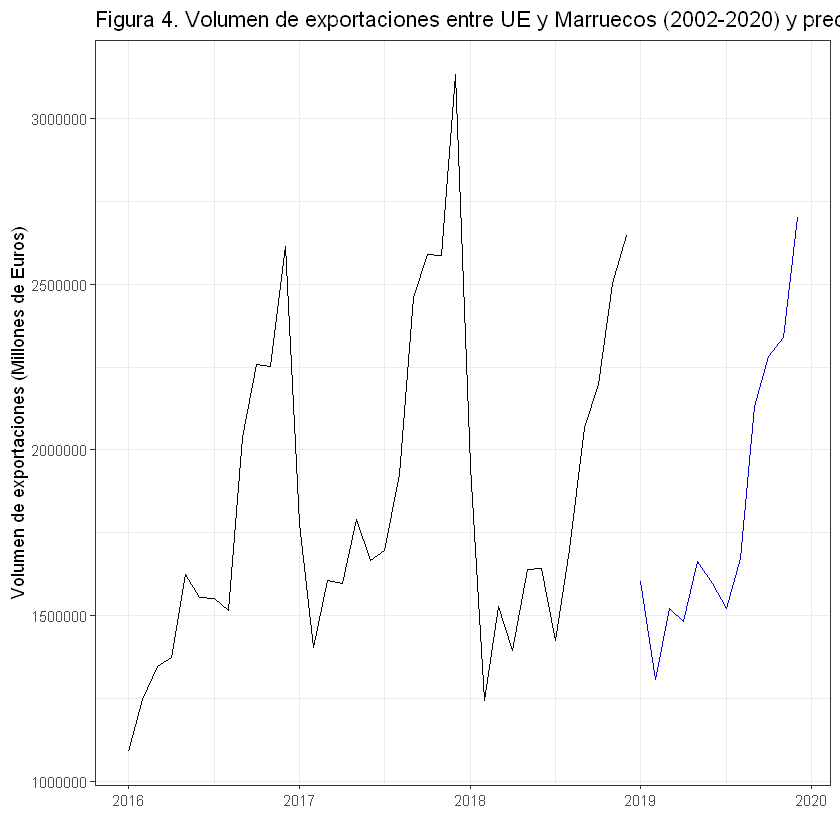

In [111]:
yellowpred <- forecast(yellowets, h = 12, level = 95)
autoplot(yellowpred,
xlab = "",
ylab = "Volumen de exportaciones (Millones de Euros)",
main = "Figura 4. Volumen de exportaciones entre UE y Marruecos (2002-2020) y predicción (2020-2023)",
PI = FALSE)
yellowpred

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



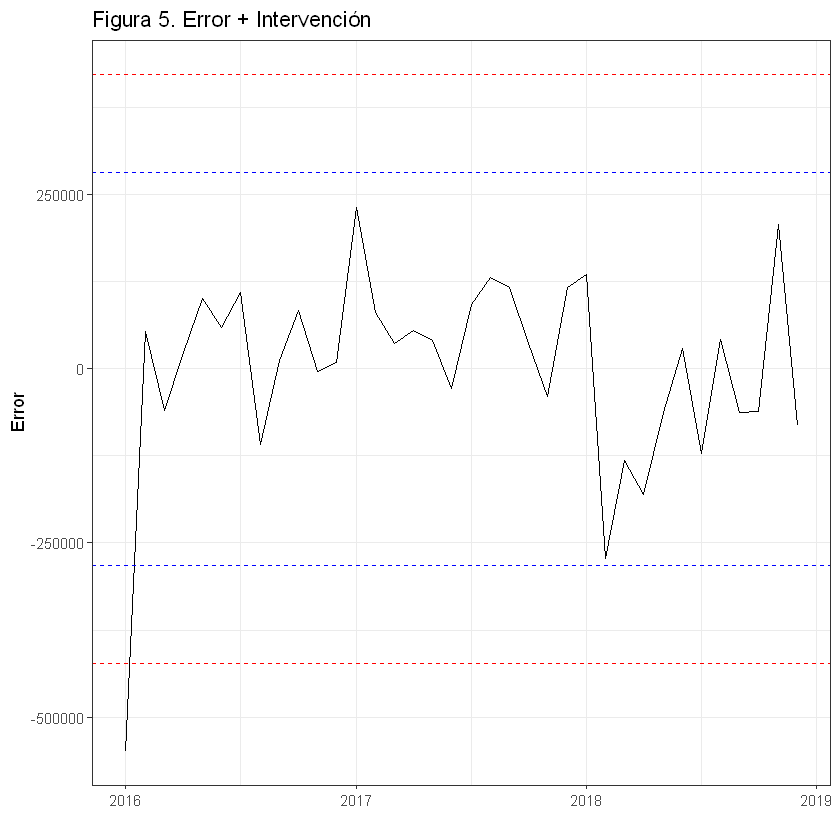

In [112]:

erroryellow <- residuals(yellowets, type = "response")
sderroryellow <- sd(erroryellow)
autoplot(erroryellow,
xlab = "",
ylab = "Error",
main = "Figura 5. Error + Intervención",
colour = "black") +
geom_hline(yintercept = c(-3, -2, 2 ,3)*sderroryellow,
colour = c("red", "blue", "blue", "red"), lty = 2) +
scale_x_continuous(breaks= seq(2016, 2020, 1))


We found an outilier corresponding to the first data taken in 2016. This makes us think about the first day that the company begins to operate, therefore it is normal that that day the benefits generated are lower than expected


         Point Forecast     Lo 95     Hi 95
Jan 2019      112951.48  75989.44 149913.52
Feb 2019       72727.08  47517.07  97937.09
Mar 2019       84195.86  53458.59 114933.12
Apr 2019       68665.31  42389.25  94941.37
May 2019       47794.14  28698.06  66890.22
Jun 2019       66747.97  38994.42  94501.52
Jul 2019       85025.21  48338.25 121712.16
Aug 2019      111300.72  61586.14 161015.29
Sep 2019      135996.48  73247.31 198745.66
Oct 2019      199739.24 104717.83 294760.65
Nov 2019      233457.63 119138.53 347776.73
Dec 2019      287999.40 143053.13 432945.68

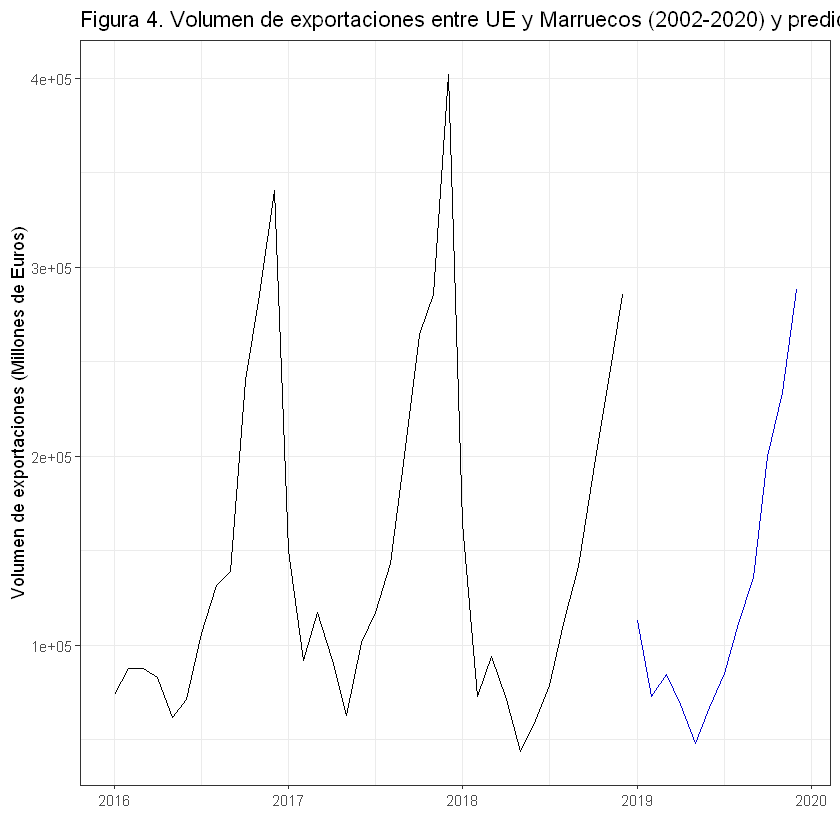

In [113]:
pinkpred <- forecast(pinkets, h = 12, level = 95)
autoplot(pinkpred,
xlab = "",
ylab = "Volumen de exportaciones (Millones de Euros)",
main = "Figura 4. Volumen de exportaciones entre UE y Marruecos (2002-2020) y predicción (2020-2023)",
PI = FALSE)
pinkpred

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



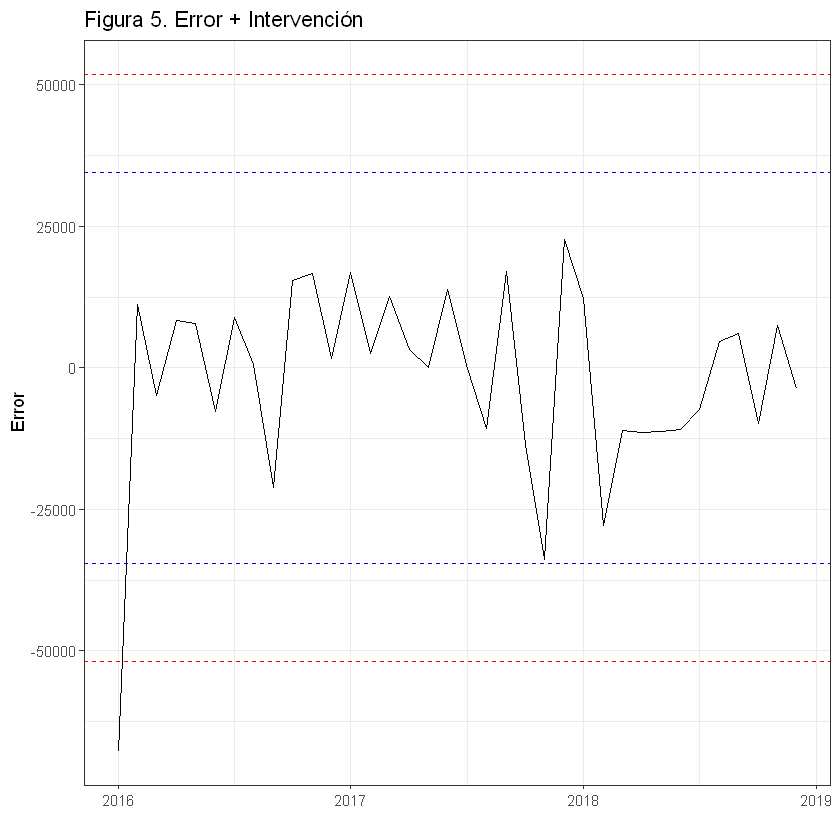

In [114]:
errorpink <- residuals(pinkets, type = "response")
sderrorpink <- sd(errorpink)
autoplot(errorpink,
xlab = "",
ylab = "Error",
main = "Figura 5. Error + Intervención",
colour = "black") +
geom_hline(yintercept = c(-3, -2, 2 ,3)*sderrorpink,
colour = c("red", "blue", "blue", "red"), lty = 2) +
scale_x_continuous(breaks= seq(2016, 2020, 1))


We found an outilier corresponding to the first data taken in 2016. This makes us think about the first day that the company begins to operate, therefore it is normal that that day the benefits generated are lower than expected

# 4. Conclusion


After the analysis carried out, we can affirm that the company in which it should be invested, and therefore the one that will generate the most profit and the one that will have the most users is the yellow company for the following reasons:

The yellow company has a greater number of users per city than the pink company.

The yellow company generates greater profit per city than the pink company

The yellow company has a greater number of users per year than the pink company

The yellow company generates more profit per year than the pink company

The yellow company will generate a future profit greater than the pink company

